# Example: Finding fault scarps

This uses the Scarp template to detect scarp-like landforms and estimate their relative age.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import scarplet as sl
from scarplet.WindowedTemplate import Scarp

This data comes from the Carrizo Plain section of the San Andreas Fault. It covers part of the Wallace Creek site, a set of offset channels and related scarps and gulleys that have been studied in detail by earthquake geologists and geophysicists.

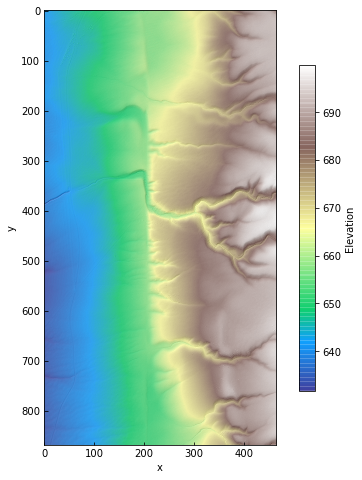

In [3]:
data = sl.load('data/faultzone.tif')
data.plot(color=True, figsize=(8,8))

In [4]:
# Look for scarps of a single morphologic age
params = {'scale': 100,
          'age': 10,
          'ang_min': -10 * np.pi / 2,
          'ang_max': 10 * np.pi / 2
         }

res = sl.match(data, Scarp, **params)

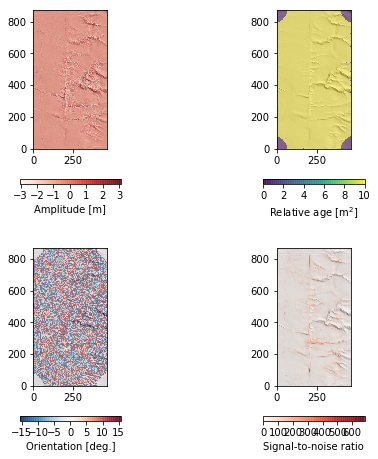

In [6]:
sl.plot_results(data, res, figsize=(8,8))

In [ ]:
# Search over all ages in default range
params.pop('age')
res = sl.match(data, Scarp, **params)

In [ ]:
sl.plot_results(data, res)